In [1]:
from sklearn.datasets import fetch_lfw_people

In [2]:
faces = fetch_lfw_people()
positive_patches = faces.images

In [3]:
positive_patches.shape

(13233, 62, 47)

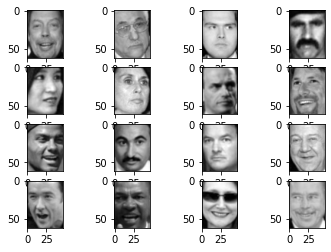

In [4]:
import matplotlib.pyplot as plt
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(positive_patches[i,:,:] , cmap='gray')

<ipython-input-5-a7867d09661b>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = color.rgb2gray(sample)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbc2ea4faf0>,
 <matplotlib.image.AxesImage at 0x7fbc17f0d760>)

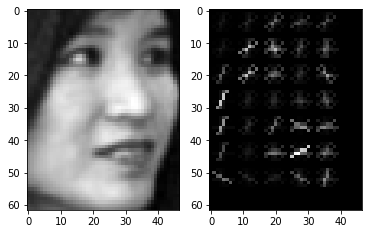

In [5]:
from skimage import color, feature
import skimage.data
sample= positive_patches[4]

img = color.rgb2gray(sample)
hog_vec, hog_vis = feature.hog(img, visualize=True)
plt.subplot(1,2,1) ,plt.imshow(sample,cmap='gray')
plt.subplot(1,2,2) ,plt.imshow(hog_vis,cmap='gray')

In [6]:
from skimage import data, transform
import numpy as np
from sklearn.feature_extraction.image import PatchExtractor
imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):

    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
    max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
      patches = np.array([transform.resize(patch, patch_size)
    for patch in patches])
    return patches
negative_patches = np.vstack([extract_patches(im, 1000, scale)
      for im in images for scale in [0.5, 1.0, 2.0]])

<ipython-input-6-69e490732420>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]


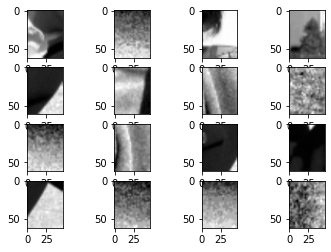

In [7]:
import matplotlib.pyplot as plt
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(negative_patches[i,:,:], cmap='gray')

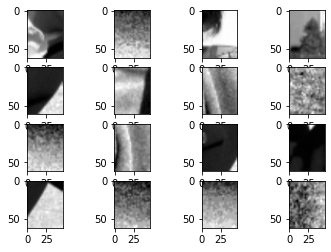

In [8]:
import matplotlib.pyplot as plt
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(negative_patches[i,:,:] , cmap='gray')

In [9]:
hog_vec.shape

(1215,)

In [10]:
#dataset equilibree
n  = min(positive_patches.shape[0],negative_patches.shape[0])
dim=hog_vec.shape[0]
Y=np.concatenate((np.ones((n,1)), np.zeros((n,1))), axis=0)
X=np.zeros((2*n,dim)) 
for i in range (n) : 
  img=positive_patches[i,:,:]
  img_gray=color.rgb2gray(img)
  hog_vec=feature.hog(img_gray)
  X[i,:]=hog_vec.reshape(1,dim)
for i in range(n):
  img=negative_patches[i,:,:]
  img_gray=color.rgb2gray(img)
  hog_vec=feature.hog(img_gray)
  X[i+n,:]=hog_vec.reshape(1,dim)

<ipython-input-10-24c28cdccdc0>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img_gray=color.rgb2gray(img)
<ipython-input-10-24c28cdccdc0>:13: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img_gray=color.rgb2gray(img)


In [11]:
dict = {'data':X , 'labels':Y}
print(dict)

{'data': array([[0.25548458, 0.29600387, 0.07282983, ..., 0.03964323, 0.04323808,
        0.08991418],
       [0.06110074, 0.02669912, 0.13924529, ..., 0.07784682, 0.05735707,
        0.17604994],
       [0.26090473, 0.26090473, 0.0086068 , ..., 0.0026164 , 0.0055565 ,
        0.00378414],
       ...,
       [0.1404805 , 0.10580823, 0.22685768, ..., 0.04952962, 0.0505105 ,
        0.        ],
       [0.18195421, 0.08145586, 0.07543442, ..., 0.12509677, 0.24958529,
        0.23331585],
       [0.01993946, 0.02290046, 0.0118614 , ..., 0.05916161, 0.12874733,
        0.11324444]]), 'labels': array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])}


In [12]:
import numpy as np
file = open("face_data.npy","wb")
np.save(file,X)
file.close

file= open("face_labels.npy","wb")
np.save(file,Y)
file.close

<function BufferedWriter.close>

In [13]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
# View the shape of the data
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((21172, 1215), (5294, 1215), (21172, 1), (5294, 1))

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


In [15]:
models = [
{ "estimater": KNeighborsClassifier(),
"params": {
"n_neighbors": [25],
"weights": ['uniform'],
"leaf_size": [25],
"p": [1],
}
},
{ "estimater": DecisionTreeClassifier(),
"params": {
"criterion": ['gini'],
"splitter": ['best'],
"max_depth": [None],
"max_features": [None],
"random_state": [42]
}
},
{ "estimater": svm.SVC(),
"params": {'C': [0.1 ], 'gamma': [1], 'kernel': ['rbf']
}
},
{ "estimater": RandomForestClassifier(),
"params": {
"criterion": ['gini'],
"bootstrap": [True],
"max_depth": [85],
"max_features": ['sqrt'],
"n_estimators": [60],
"random_state": [42]
}
}
]
column_names = ["KNeighbors"]
entries = []
max_acc = 0
best_model = None
for model in models:
   print(model["estimater"])
# Create model
clf = model["estimater"]
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = model["params"],cv = 5)
# Fit the model
grid_search.fit(X_train, Y_train);
# Make predictions on the test set compute accuracy metric
predicted = grid_search.predict(X_test)
acc = accuracy_score(predicted, Y_test)
entries.append(acc)
print(grid_search.best_params_)
# Get the best model with the highest accuracy
if acc > max_acc:
  max_acc = acc
best_model = grid_search

KNeighborsClassifier()
DecisionTreeClassifier()
SVC()
RandomForestClassifier()


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 85, 'max_features': 'sqrt', 'n_estimators': 60, 'random_state': 42}


In [16]:
print(models[0])

{'estimater': KNeighborsClassifier(), 'params': {'n_neighbors': [25], 'weights': ['uniform'], 'leaf_size': [25], 'p': [1]}}


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


    Estimator  Accuracy
0  KNeighbors  0.989611


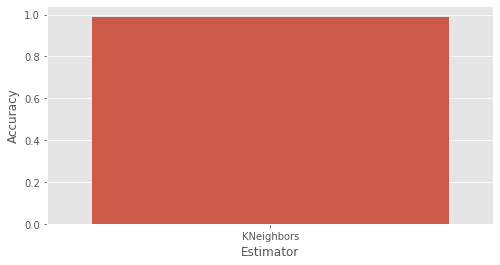

In [18]:
plt.style.use('ggplot')
df = pd.DataFrame({"Estimator": column_names, "Accuracy": entries})
plt.figure(figsize=(8, 4))
sns.barplot(x='Estimator', y='Accuracy', data=df)
print(df)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate_preds(y_true, y_preds):
 """
 Performs evaluation comparison on y_true labels vs. y_pred labels
 on a classification.
 """
 accuracy = accuracy_score(y_true, y_preds)
 precision = precision_score(y_true, y_preds, average='micro')
 recall = recall_score(y_true, y_preds, average='micro')
 f1 = f1_score(y_true, y_preds, average='micro')
 metric_dict = {"accuracy": round(accuracy, 2),
 "precision": round(precision, 2),
 "recall": round(recall, 2),
 "f1": round(f1, 2)}
 
 return metric_dict

In [20]:
y_preds=best_model.predict(X_test)
dict_perf=evaluate_preds(Y_test,y_preds)
print(dict_perf)

{'accuracy': 0.99, 'precision': 0.99, 'recall': 0.99, 'f1': 0.99}


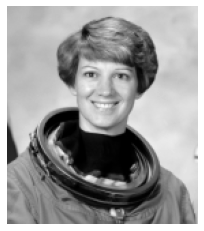

In [21]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
plt.imshow(test_image, cmap='gray')
plt.axis('off');


In [22]:
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
               patch = transform.resize(patch, patch_size)
            yield (i, j), patch
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])


In [23]:
labels =best_model.predict(patches_hog)
labels.sum()


68.0

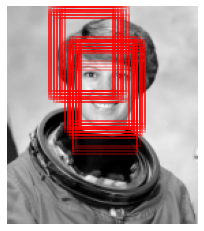

In [24]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
for i, j in indices[labels == 1]:
  ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                             alpha=0.3, lw=2, facecolor='none'))